## Overview

My senior project was attempting to use a reinforcement learning algorithm based on a [Deep Deterministic Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/ddpg.html) model for use with a continuous observation *and* action space, in order to solve the [Square Packing in a Square](https://en.wikipedia.org/wiki/Square_packing) problem for N=11 squares.

You can read the initial proposal [here](https://smartycope.org/posts/SquarePacking/)

This file/post is intended to be entirely self-contained. You should be able to run/copy it directly and have it all work.

In [ ]:
#| code-fold: true
#| code-summary: "Spoiler Alert"
# I did not succeed


I created a custom RL enviorment, built off the [Gymnasium](https://gymnasium.farama.org/) library, specifically my own personal SimpleGym class, published my own [Cope](https://pypi.org/project/Cope/) package. 

Both the action and observation spaces have the shape `(3*N, )` (N is the number of squares, so 11) where each square has an x, y and rotation values. The actor's actions simply get added to the current square positions and rotations (since the actor actions can be negative), so the actor can make small adjustments to squeze the squares closer to each other.

I went though several different versions of the reward function. Here's my final version, with explanations of what each part is doing:

In [19]:
#| filename: "Reward Function"
def _get_reward(self):
    # The score starts off as positive, because we generally prefer longer episodes
    score = 100 # Linear

    # These are all customizable coefficients
    small_side_len = 5.5 # Scalar
    longevity_importance = .5 # Multiplied
    side_importance = 100 # Multiplied
    centered_importance = 0 # Exponential
    boundary_badness = 0 # Linear
    if not self.boundary:
        boundary_badness = 0

    # We like longer episodes
    score += self.steps * longevity_importance

    # This is the "main" value we want to optimize: the side length
    # All the other stuff is to help it optimize this quicker
    # It's set so "small" side lengths set a positive reward,
    # and "large" side lengths set a negative reward
    score -= (self.side_len - small_side_len) * side_importance
    # I tried making it exponential for a time (it didn't seem to help)
    # score -= math.e**(self.side_len * side_importance)

    # We like it if they're in a small area
    if self.side_len < small_side_len and self.start_config != 'array':
        score += 200

    # We want to incentivize not touching, instead of disincentivizing touching,
    # because this way it doesn't also disincentivize longer runs
    # (if the reward is positive by default (not touching), then a longer run is okay)

    # We don't like it when they overlap at all
    # This isn't relevant when we don't allow overlap in the first place
    if self.overlap_area > 0:
        score -= 100_000
        # We really don't like it when they overlap -- the configuration is invalid if they do
        score -= math.e**(self.overlap_area)

    # I don't want them to just push up against the edges
    # This creates a "boundary" on the sides which, when squares are in it, the reward goes down
    if boundary_badness or centered_importance:
        for x, y, _rot in self.squares:
            # Left
            if x < self.boundary:
                score -= boundary_badness
            # Top
            if y < self.boundary:
                score -= boundary_badness
            # Right
            if abs(x - self.search_space) < self.boundary:
                score -= boundary_badness
            # Bottom
            if abs(y - self.search_space) < self.boundary:
                score -= boundary_badness

            # We want the squares to be close to the center
            # This is in the same loop out for the sake of efficiency
            if centered_importance:
                score -= (math.e ** dist([x, y], [self.search_space / 2, self.search_space / 2]) * centered_importance) / self.N

    return score

## Dependant Code

For reproducibility's sake, here is the rest of the relevant custom code I used in this project (because although my Cope package is published, it's *not* stable):

In [2]:
#| code-fold: true
#| code-summary: "RedirectStd"
#| filename: "misc.py"
import io, sys
from random import randint

class RedirectStd:
    def __init__(self, stdout=None, stderr=None):
        if isinstance(stdout, io.TextIOBase):
            self._stdout = stdout
        else:
            self._stdout = open(stdout or os.devnull, 'w')
        if isinstance(stderr, io.TextIOBase):
            self._stderr = stderr
        else:
            self._stderr = open(stderr or os.devnull, 'w')

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        self._stdout.close(); self._stderr.close()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

def interpret_percentage(percentage:int | float) -> float:
    if isinstance(percentage, bool):
        return float(percentage)
    elif percentage > 1:
        return percentage / 100
    return percentage

def percent(percentage:int | float):
    ''' Usage:
        if (percent(50)):
            <code that has a 50% chance of running>
        NOTE: .5 works as well as 50
    '''
    return randint(1, 100) < interpret_percentage(percentage)*100


In [4]:
#| code-fold: true
#| code-summary: "SimpleGym"
#| filename: "SimpleGym.py"
from sys import exit
from abc import ABC
from time import sleep, time as now
import gymnasium as gym
import pygame

class SimpleGym(gym.Env, ABC):
    """ A simplified Gymnasium enviorment that uses pygame and handles some stuff for you, like rendering
        keeping track of steps, returning the right things from the right functions, event handling,
        including some default keyboard shortcuts, and some debugging features. Includes easy ways
        to print to the screen.

        **Rendering**
            By default, it's set to render the enviorment according to the function render_pygame, which
            should render everything to self.surf. If you would like to specify other rendering methods,
            define them as `render_{method_name}`, and render() will handle it for you. There's no need
            to manually overwrite the render() method.

        **Printing**
            There are 3 ways to print to the screen:
                `show_vars`: accessable either via the constructor or as a member
                    This is a dictionary of {name: member} of members you want to have printed
                    on the screen. The keys can be any string, and the values must be valid members
                    of this class. The screen is updated as the member changes.
                `show_strings`: accessable either via the constructor, as a member, or the show() function
                    This is a list of strings that are printed to the screen. They won't change.
                    Useful for showing config options and the like. They are always printed first.
                `print`: a dictionary member. The keys are arbitrary and not printed. The values
                    are printed to the screen. The reason it's a dictionary and not a list is simply
                    for easy indexing: you can change this in the middle of the running loop, and
                    it will get added to the screen. Just make sure to reuse the keys.
                    Attempting to set an item on an instance will also set it to print
                    (i.e. `env['a'] = 'string'` is the same as `env.print['a'] = 'string'`)

        Default key handling:
            q closes the window
            space toggles pause
            i increments a single frame
            u runs the debug_button()
            r runs reset() immediately
            f toggles whether we're limiting ourselves to FPS or not
            h shows a help menu on screen
            >/< increase and decrease the FPS

        In order to use this effectively, you need to overload:
            __init__(), if you want to add any members
            _get_obs()
            _get_reward()
            _step(action), don't overload step(), step() calls _step
            _reset(seed=None, options=None), if you need any custom reset code (don't overload reset())
            render_pygame(), render to self.surf
        and optionally:
            _get_terminated(), if you want to use custom terminated criteria other than just max_steps
                You *don't* need to call super()._get_terminated()
            _get_info(), if you want to include info
            handle_event(event), for handling events
            debug_button(), for debugging when you press the u key
            _get_truncated(), if you want to include truncated

        Helpful members provided:
            `width`, `height`: the dimentions of the screen
            `size`: set to self.width, for compatibility's sake
            `just_reset`: is set to True by reset() and False by step()
            `steps`: the number of steps in the current episode
            `total_steps`: the total number of steps taken
            `reset_count`: a count of the number of times reset() has been called
            `surf`: the surface to draw to in render_pygame()
            `paused`: True if paused
            `increment`: set to True internally to denote a single step while paused. step() sets
                to False
    """

    FPS_STEP = 2
    SHOW_HELP_FADE_TIME = 10
    FONT_SIZE = 10
    HELP_TEXT = """
        q: close window
        space: toggle pause
        i: increment a single frame
        u: run debug_button()
        r: reset
        f: toggle limit FPS
        </>: change FPS
        d: toggle displaying
        h: show/hide this menu
    """

    def __init__(self,
        max_steps=None,
        screen_size=300,
        fps=None,
        name='SimpleGym Enviorment',
        show_vars={},
        show_strings=[],
        start_paused=False,
        render_mode='pygame',
        displaying=True,
        print=True,
        assert_valid_action=True,
        background_color=(20, 20, 20),
        print_color=(200, 20, 20, 0),
        show_events=False,
        verbose=True,
    ):
        """ This should be called first, if you  want to use the members like self.size
            Parameters:
                `max_steps`: if positive, sets the maximum number of steps before the env resets
                    itself. If None or negative, no limit
                `screen_size`: the size of the pygame window. Can be a 2 item tuple of (width, height)
                    or a single int if the window is to be square
                `fps`: controls how fast the simulation runs. Set to negative or None to have no limit
                `name`: the name of the enviorment shown on the window title
                `show_vars`: a dictionary of {name: member} of members you want to have printed
                    on the screen. The keys can be any string, and the values must be valid members
                    of this class
                `show_strings`: a list of strings you want to have printed on the screen
                `start_paused`: self-explanitory
                `show_events`: prints events, other than mouse movements, for debugging purpouses
                `render_mode`: part of the gymnasium specification. Must be either None or 'pygame',
                    unless you manually override the render() method
                `displaying`: turn off to not render, to go faster
                `print`: whether we automatically render self.print to the screen. You can use self.display() to
                    display to a Jupyter Notebook instead. It still renders show_strings.
                `assert_valid_action`: ensures that actions given to step() are within the action_space
                `background_color`: a 3 item tuple specifying the background color
                `print_color`: a 4 item tuple (the 4th index being alpha) specifying the color of
                    the extra data printed to the screen
                `verbose`: when set to True, it simply adds `fps`, `reset_count`, `steps`, `total_steps`
                    to `show_vars`. Also shows the help menu for the first few seconds
        """
        self.metadata = {"render_modes": list({'pygame', render_mode}), "render_fps": fps}
        assert render_mode is None or render_mode in self.metadata["render_modes"], render_mode

        self.background_color = background_color
        self.print_color = print_color
        self.name = name
        self.show_events = show_events
        self.fps = self.FPS = fps

        self.max_steps = max_steps
        self.steps = 0
        self.total_steps = 0
        self.paused = start_paused
        self.increment = False
        self.just_reset = False
        self.reset_count = 0

        self.render_mode = render_mode
        self.screen_size = screen_size if isinstance(screen_size, (tuple, list)) else (screen_size, screen_size)
        self.width, self.height = self.screen_size
        self.size = self.width
        self.screen = None
        self.surf = None
        self.font = None
        self._displaying = displaying
        self._print = print

        self.print = {}
        self.show_strings = show_strings
        self.show_vars = show_vars
        if verbose:
            self.show_vars['FPS'] = 'fps'
            self.show_vars['Episode'] = 'reset_count'
            self.show_vars['Step'] = 'steps'
            self.show_vars['Total Steps'] = 'total_steps'

        # We want to ensure that reset gets called before step. Nowhere else does this get set to False
        self._previous_step_called = None
        self._assert_valid_action = assert_valid_action
        self._prints_surf = None
        self._original_fps = fps
        self._show_help = verbose
        self._rendered_helps = None

    def _get_obs(self):
        raise NotImplementedError

    def _get_info(self):
        return {}

    def _get_truncated(self):
        return False

    def __default_get_terminated(self):
        """ Called internally so max_steps still works even if _get_terminated is overloaded """
        term = False
        if self.max_steps is not None and self.max_steps > 0 and self.steps > self.max_steps:
            term = True

        return self._get_terminated() or term

    def _get_terminated(self):
        """ By default this just terminates after max_steps have been reached """
        return False

    def _get_reward(self):
        raise NotImplementedError

    def reset(self, seed=None, options=None):
        """ This sets the self.np_random to use the seed given, resets the steps, and returns the
            observation and info. Needs to be called first, if you're depending on self.np_random,
            or steps equalling 0, but also needs to return what this returns.
        """
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self._reset(seed=seed, options=options)

        self.steps = 0
        self.just_reset = True
        self.reset_count += 1

        return self._get_obs(), self._get_info()

    def _reset(seed=None, options=None):
        raise NotImplementedError()

    def step(self, action):
        """ Call this last, and return it """
        assert self.reset_count > 0, "step() called before reset(). reset() must be called first."

        # If it's paused, don't bother checking if it's a valid action
        if self._assert_valid_action and not self.paused or self.increment:
            assert self.action_space.contains(action), "Action given not within action_space"

        if self.paused and not self.increment:
            return self._get_obs(), self._get_reward(), self.__default_get_terminated(), self._get_truncated(), self._get_info()

        self._step(action)

        if not self.paused or self.increment:
            self.steps += 1
            self.total_steps += 1
        self.just_reset = False
        self.increment = False

        if self.fps is not None and self.fps > 0 and self._previous_step_called is not None:
            # Sleep for the amount of time until we're supposed to call step next
            wait_for = (1/self.fps) - (now() - self._previous_step_called)
            # If calculations elsewhere took so long that we've already past the next frame time,
            # don't sleep, just run
            if wait_for > 0:
                sleep(wait_for)

        self._previous_step_called = now()
        return self._get_obs(), self._get_reward(), self.__default_get_terminated(), self._get_truncated(), self._get_info()

    def _step(action):
        raise NotImplementedError()

    # @ensure_imported(pygame)
    def _init_pygame(self):
        import pygame
        if self.screen is None:
            pygame.init()
            pygame.display.init()
            pygame.display.set_caption(self.name)
            self.screen = pygame.display.set_mode(self.screen_size)

        if self.font is None:
            self.font = pygame.font.SysFont("Verdana", self.FONT_SIZE)

        if self.surf is None:
            self.surf = pygame.Surface(self.screen_size)
            self.surf.convert()
            # self.surf.fill((255, 255, 255))

        if self._prints_surf is None:
            self._prints_surf = pygame.Surface(self.screen_size)
            self._prints_surf.convert()
            self._prints_surf.fill(self.background_color)

        if self._rendered_helps is None:
            self._rendered_helps = [
                self.font.render(line, True, self.print_color)
                for line in self.HELP_TEXT.splitlines()
            ]

    def render(self):
        if not self._displaying:
            self._handle_events()
            return

        if self.render_mode == 'pygame':
            self._init_pygame()
            # Fill the background
            self.surf.fill(self.background_color)

            self.render_pygame()

            # The strings in show_strings should come first
            strings = self.show_strings.copy()
            # Get the texts from self.show_vars
            length = len(max(self.show_vars.keys(), key=len))
            strings += [
                f'{name}: {" "*(length - len(name))} {getattr(self, var, f"{var} is not a member")}'
                for name, var in self.show_vars.items()
            ]

            if self._print:
                # Add the texts from self.prints
                strings += list(self.print.values())

                # Draw all the text onto the surface
                for offset, string in enumerate(strings):
                    self.surf.blit(self.font.render(string, True, self.print_color), (5, 5 + offset*(self.FONT_SIZE + 2)))

                if self._show_help:
                    for offset, string in enumerate(self._rendered_helps):
                        max_width = max(self._rendered_helps, key=lambda h: h.get_size()[0]).get_size()[0]
                        self.surf.blit(string, (self.width - max_width, offset*(self.FONT_SIZE + 2)))

            # If we're not displaying, but still running, show some sort of indication, so they know we haven't frozen
            if not self._displaying:
                self.surf.blit(pygame.font.SysFont("Verdana", 25).render('PAUSED', True, self.print_color), (100, 50))

            # I don't remember what this does, but I think it's important
            self.surf = pygame.transform.scale(self.surf, self.screen_size)

            # Display to screen
            self.screen.blit(self.surf, (0, 0))
            self._handle_events()
            pygame.display.flip()

        else:
            if hasattr(self, f'render_{self.render_mode}'):
                getattr(self, f'render_{self.render_mode}')()
            else:
                raise AttributeError(f"No render_{self.render_mode} function provided")

    def debug_button(self):
        pass

    def _handle_events(self):
        for e in pygame.event.get():
            match e.type:
                case pygame.QUIT:
                    self.close()
                    exit(0)
                case pygame.KEYDOWN:
                    if e.key == pygame.K_ESCAPE:
                        self.close()
                        exit(0)
                    elif e.key == pygame.K_SPACE:
                        self.paused = not self.paused

                    match e.unicode:
                        case 'q':
                            self.close()
                            exit(0)
                        case 'u':
                            self.debug_button()
                        case 'i':
                            self.increment = True
                            # If it's not paused, make it paused
                            self.paused = True
                        case 'r':
                            self.reset()
                        case 'f':
                            if self.fps is None:
                                self.fps = self._original_fps
                            else:
                                self._original_fps = self.fps
                                self.fps = None
                        case '>' | '.':
                            if self.fps is None:
                                self.fps = self.FPS_STEP
                            else:
                                self.fps += self.FPS_STEP
                        case '<' | ',':
                            if self.fps is None:
                                self.fps = 0
                            else:
                                self.fps -= self.FPS_STEP
                        case 'h':
                            self._show_help = not self._show_help
                        case 'd':
                            self._displaying = not self._displaying
                        case _:
                            self.handle_event(e)
                case _:
                    self.handle_event(e)
                    if self.show_events and e.type != pygame.MOUSEMOTION:
                        print(e)
        pygame.event.pump()

    def handle_event(self, event):
        pass

    def show(self, string):
        """ Sets a given string to be shown on the pygame window """
        self.show_strings.append(string)

    def __setitem__(self, index, string):
        self.print[index] = string

    def display(self, to=None):
        from IPython.display import HTML, display
        if to is not None:
            to.update(HTML('<br/>'.join(self.show_strings + list(self.print.values()))))
        else:
            display(HTML('<br/>'.join(self.show_strings + list(self.print.values()))), clear=True)

    def close(self):
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None
            self.font = None


In [5]:
#| code-fold: true
#| code-summary: "SquareEnv"
#| filename: "SquareEnv2.py"
import itertools
import gymnasium as gym
import random
from typing import Iterable, Literal
from gymnasium import spaces
import shapely.geometry as sg
import shapely.ops as so
import matplotlib.pyplot as plt
import numpy as np
import pygame
from pygame import gfxdraw
import numpy as np
from typing import List, Tuple
import math
from math import cos, dist, sin, tan, pi
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely.affinity import rotate
from shapely.ops import unary_union
# from Cope.gym import SimpleGym
# This is safe to remove if you're using pygame or nothing to render
from IPython.display import display


def multiPolygon2Space(multi):
    rtn = []
    for geom in multi.geoms:
        # Compute the x, y, and rotation angle values for this square
        # Skip the last coordinate, because the first and last are the same
        corner1, corner2, corner3, corner4, _ = geom.exterior.coords

        rot_rad = math.atan2(corner4[1] - corner3[1], corner4[0] - corner3[0])
        # Normalize the angles to all be positive (due to our space requirements)
        # if rot_rad < 0:
        #     rot_rad += math.pi/2

        # Add the x, y, and rotation angle values to the result list
        rtn.append(np.array((
            # x
            (corner1[0] + corner2[0] + corner3[0] + corner4[0]) / 4,
            # y
            (corner1[1] + corner2[1] + corner3[1] + corner4[1]) / 4,
            # Rotation (radians)
            rot_rad
        )))

    return np.array(rtn)

def space2MultiPolygon(space, side_len=1):
    # Autoreshape it if it's flat
    if len(space.shape) == 1:
        space = space.reshape((int(len(space)/3), 3))
    # return MultiPolygon([Polygon(corners) for corners in compute_corners(space, sideLen=side_len)])
    return MultiPolygon(map(Polygon, compute_all_corners(space, side_len=side_len)))

def compute_all_corners(squares: List[Tuple[float, float, float]], side_len=1) -> np.ndarray:
    # return np.array([compute_corners(square) for square in squares])
    return np.array(list(map(lambda s: compute_corners(s, side_len=side_len), squares)))

def compute_corners(square: Tuple[float, float, float], side_len=1) -> np.ndarray: #[float, float, float, float]:
    # Rotation is in radians
    x, y, rot = square
    # Compute the coordinates of the four corners of the square
    half = side_len / 2
    return np.array([
        (x + corner[0]*math.cos(rot) - corner[1]*math.sin(rot),
         y + corner[0]*math.sin(rot) + corner[1]*math.cos(rot))
        for corner in [(half, half), (half, -half), (-half, -half), (-half, half)]
    ])

class SquareEnv(SimpleGym):
    def __init__(self, *args,
                 N            = 4,
                 search_space = None,
                 shift_rate   = .01,
                 rot_rate     = .001,
                #  flatten      = False,
                 max_steps    = 1000,
                 boundary     = 0,
                 max_overlap  = .5,
                 start_config:Literal['valid', 'array', 'random'] = 'valid',
                 screen_size  = None,
                 # mixed is loop the rotation, but clip the position
                 bound_method:Literal['clip', 'loop', 'mixed'] = 'mixed',
                 disallow_overlap=False,
                 **kwargs,
            ):
        """ N is the number of boxes
            search_space is the maximum length of the larger square we're allowing the smaller
                squares to be in
            shift_rate is the maximum rate at which we can shift the x, y values per step
            rot_rate is the maximum rate at which we can rotate a box per step
            start_config defines we we reset the squares.
                If `random`, the boxes are randomly placed
                If `valid`, the boxes are randomly placed, but not overlapping
                If `array`, the boxes are arrayed in a grid, but are randomly "jiggled"
        """
        super().__init__(
            *args,
            max_steps=max_steps,
            screen_size=screen_size,
            background_color=(255, 255, 255),
            print_color=(0, 0, 0),
            name='Square Packing',
            show_vars={'FPS': 'fps'},
            assert_valid_action=False,
            verbose=False,
            **kwargs
        )
        self._show_help = True

        if search_space is None:
            search_space = N

        # self.render_mode = render_mode
        self.search_space = search_space
        self.shift_rate = shift_rate
        self.rot_rate = rot_rate
        self.N = N
        # self.steps = 0
        self.scale = 20
        self.offset = 50
        self.bound_method = bound_method.lower()
        self.max_overlap = max_overlap
        self.max_steps = max_steps
        self.boundary = boundary
        self.disallow_overlap = disallow_overlap
        size = self.search_space*self.scale+(self.offset*2)
        if screen_size is None:
            self.screen_size = np.array((size, size))
        # self.screen = None
        # self.surf = None
        # self.extraNums = None
        # self.userSurf = None
        # self.userSurfOffset = 0
        # self._userPrinted = False
        # self.font = None
        # self._flat = flatten
        self.start_config = start_config
        self.movement = np.zeros((self.N, 3))
        self.squares: np.ndarray # with the shape (N, 3): it gets flattened/reshaped to interface with the spaces

        ### Define the spaces ###
        # if self._flat:
        self.observation_space = spaces.Box(low=np.zeros((N*3,)),
            high=np.array([[search_space]*N, [search_space]*N, [math.pi/2]*N]).T.flatten(),
            dtype=np.float64, shape=(N*3,))

        # The action space is shifting & rotating the squares little bits at a time
        self.action_space = spaces.Box(low=np.array([[-shift_rate]*N, [-shift_rate]*N, [-rot_rate]*N]).T.flatten(),
            high=np.array([[shift_rate]*N, [shift_rate]*N, [rot_rate]*N]).T.flatten(),
            dtype=np.float64, shape=(N*3,))

        # else:
        #     self.observation_space = spaces.Box(low=np.zeros((N,3)),
        #                                         high=np.array([[search_space]*N, [search_space]*N, [math.pi/2]*N]).T,
        #                                         dtype=np.float64, shape=(N,3))

        #     # The action space is shifting & rotating the squares little bits at a time
        #     self.action_space = spaces.Box(low=np.array([[-shift_rate]*N, [-shift_rate]*N, [-rot_rate]*N]).T,
        #                                 high=np.array([[shift_rate]*N, [ shift_rate]*N, [ rot_rate]*N]).T,
        #                                 dtype=np.float64, shape=(N,3))

    def _get_obs(self):
        return self.squares.flatten()

    def _get_info(self):
        return {
            # 'Overlaps': not self.squares.is_valid,
            'overlap': self.overlap_area,
            'len': self.side_len,
            'wasted': self.wasted_space,
            # 'loss': lossFunc(self.squares),
        }

    def _get_terminated(self):
        # Optimal: 3.789, best known: 3.877084
        # There's no overlapping and we're better than the previous best
        if self.N == 11 and self.side_len < 3.877084 and self.is_valid():
            print('Holy cow, we did it!!!')
            print('Coordinates & Rotations:')
            print(self.squares)
            with open('~/SQUARE_PARAMETERS.txt', 'w') as f:
                f.write(str(self.squares))
            return True

        # If we're almost entirely overlapping, just kill it
        if self.overlap_area > self.max_overlap:
            return True

        # If we're pretty small, and we're only making small adjustments, don't reset, we're doing good!
        if not np.any(np.median(self.movement, axis=0)) and self.side_len > 4.5:
            return True

        return False

    def _get_reward(self):
        # We generally prefer living longer
        score = 100 # Linear
        small_side_len = 5.5 # Scalar
        longevity_importance = .5 # Multiplied
        side_importance = 100 # Multiplied
        centered_importance = 0 # Exponential
        boundary_badness = 0 # Linear
        if not self.boundary:
            boundary_badness = 0

        score += self.steps * longevity_importance

        # score -= math.e**(self.side_len * side_importance)
        score -= (self.side_len - small_side_len) * side_importance

        # We like it if they're in a small area
        if self.side_len < small_side_len and self.start_config != 'array':
            score += 200

        # We want to incentivize not touching, instead of disincentivizing touching,
        # because this way it doesn't also disincentivize longer runs
        # (if the reward is positive by default (not touching), then a longer run is okay)

        # We don't like it when they overlap at all
        if self.overlap_area > 0:
            score -= 100_000
            # We really don't like it when they overlap
            score -= math.e**(self.overlap_area)

        # This is essentially a percentage of how much they're overlapping
        # score -= self.overlap_area / (self.N - self.max_overlap)**2

        # I don't want them to just push up against the edges
        if boundary_badness or centered_importance:
            for x, y, _rot in self.squares:
                # Left
                if x < self.boundary:
                    score -= boundary_badness
                # Top
                if y < self.boundary:
                    score -= boundary_badness

                # Right
                if abs(x - self.search_space) < self.boundary:
                    score -= boundary_badness
                # Bottom
                if abs(y - self.search_space) < self.boundary:
                    score -= boundary_badness

                # We want the squares to be close to the center
                if centered_importance:
                    score -= (math.e ** dist([x, y], [self.search_space / 2, self.search_space / 2]) * centered_importance) / self.N

        return score

    def _step(self, action):
        # The action is given flattened, but self.squares looks like [[x, y, radians], ...]
        assert action.shape == (self.N*3,), f'Action given to step is the wrong shape (Expected shape ({self.N*3},), got {action.shape})'
        action = action.reshape((self.N,3))

        # Compute the shifted squares
        new_squares = self.squares + action

        # Make sure we don't leave the observation space
        if self.bound_method == 'clip':
            new_squares[:,:2][new_squares[:,:2] >  self.search_space] = self.search_space
            new_squares[:,:2][new_squares[:,:2] < 0]                  = 0
            new_squares[:,2][new_squares[:,2]   > math.pi/2]          = math.pi/2
            new_squares[:,2][new_squares[:,2]   < 0]                  = 0
        elif self.bound_method == 'loop':
            new_squares[:,:2][new_squares[:,:2] >  self.search_space] = 0
            new_squares[:,:2][new_squares[:,:2] < 0]                  = self.search_space
            new_squares[:,2][new_squares[:,2]   > math.pi/2]          = 0
            new_squares[:,2][new_squares[:,2]   < 0]                  = math.pi/2
        # Loop the rotation, but clip the position
        elif self.bound_method == 'mixed':
            new_squares[:,:2][new_squares[:,:2] >  self.search_space] = self.search_space
            new_squares[:,:2][new_squares[:,:2] < 0]                  = 0
            new_squares[:,2][new_squares[:,2]   > math.pi/2]          = 0
            new_squares[:,2][new_squares[:,2]   < 0]                  = math.pi/2
        else:
            raise TypeError(f'Unknown `{self.bound_method}` bound_method provided')

        if self.disallow_overlap:
            for i1, square1 in enumerate(new_squares):
                # i1+1, because if a intercets b, then b intersects a. We don't need to check it again
                # We also don't need to check if a intersects a.
                for i2, square2 in enumerate(new_squares[i1+1:], start=i1+1):
                    if Polygon(compute_corners(square1)).intersects(Polygon(compute_corners(square2))):
                        new_squares[i1] = self.squares[i1]
                        new_squares[i2] = self.squares[i2]

        self.movement = self.squares - new_squares
        self.squares = new_squares

    def _reset(self, seed=None, options=None):
        # Why does the Space constructor have a seed and not the .sample() method??
        if seed is None:
            # We can't be deterministic AND auto start at a valid point
            # Also make sure we're within the boundaries
            match self.start_config:
                case 'random':
                    self.squares = self.observation_space.sample().reshape((self.N, 3))
                case 'valid':
                    self.squares = self.observation_space.sample().reshape((self.N, 3))
                    while not self.within_boundary or not self.is_valid(False):
                        self.squares = self.observation_space.sample().reshape((self.N, 3))
                case 'array':
                    cols = math.ceil(math.sqrt(self.N))
                    added = 0
                    # Minimum so they can't overlap: 1.4142135623730951 (math.sqrt((.5**2)*2) * 2)
                    gap = 2
                    startx = self.boundary + gap / 2
                    starty = self.boundary + gap / 2
                    squares = []
                    x = startx
                    y = starty
                    col = 0
                    while added < self.N:
                        squares.append([x, y, random.uniform(0, math.pi/2)])
                        added += 1
                        col += 1

                        if col >= cols:
                            y += gap
                            x = startx
                            col = 0
                        else:
                            x += gap
                    self.squares = np.array(squares)
                case _:
                    ValueError('Invalid start_config parameter given')

        else:
            # This is untested after the refactor
            # if self._flat:
            self.squares = spaces.Box(
                low  =np.zeros((self.N,3)),
                high =np.array([[self.search_space]*self.N, [self.search_space]*self.N, [math.pi/2]*self.N]).T,
                dtype=np.float64,
                shape=(self.N,3),
                seed =seed,
            ).sample()
            # else:
            #     self.squares = spaces.Box(low=np.zeros((self.N*3,)),
            #                     high=np.array([[self.search_space]*self.N, [self.search_space]*self.N, [math.pi/2]*self.N]).T.flatten(),
            #                     dtype=np.float64, shape=(self.N*3,), seed=seed).sample().reshape((self.N, 3))


    def is_valid(self, shallow=True):
        """ True if there's no overlapping """
        return (shallow and self.disallow_overlap) or space2MultiPolygon(self.squares).is_valid

    @property
    def overlap_area(self):
        if self.disallow_overlap:
            return 0

        area = 0
        # for i, square1 in enumerate(self.squares.geoms):
            # for square2 in list(self.squares.geoms)[i+1:]:
        for square1, square2 in itertools.combinations(self.squares, 2):
            area += Polygon(compute_corners(square1)).intersection(Polygon(compute_corners(square2))).area
        return area

    def min_rotated_rect_extents(self, side_len=1) -> Tuple['minx', 'miny', 'maxx', 'maxy']:
        corners = compute_all_corners(self.squares)
        xs = corners[:,:,0]
        ys = corners[:,:,1]
        return np.min(xs), np.min(ys), np.max(xs), np.max(ys)

    @property
    def side_len(self):
        # minx = np.min(self.squares[])
        # x, y = self.squares.minimum_rotated_rectangle.exterior.coords.xy
        minx, miny, maxx, maxy = self.min_rotated_rect_extents()
        return max(maxx - minx, maxy - miny)
        # edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
        # return max(edge_length)

    @property
    def wasted_space(self):
        return self.side_len**2 - self.N

    @property
    def within_boundary(self):
        if not self.boundary:
            return True
        for x, y, rot in self.squares:
            if (x < self.boundary or
                y < self.boundary or
                abs(x - self.search_space) < self.boundary or
                abs(y - self.search_space) < self.boundary
            ): return False
        return True


    # def render_matplotlib(self):
        # plt.gca().set_aspect('equal')
        # for geom in self.squares.geoms:
        #     xs, ys = geom.exterior.xy
        #     plt.fill(xs, ys, alpha=0.5, fc='r', ec='none')
        # plt.show()

    def render_shapely(self):
        # self._display_id.update(space2MultiPolygon(self.squares))
        display(space2MultiPolygon(self.squares), clear=True)

    def render_pygame(self):
        scaled_squares = self.squares.copy()
        scaled_squares[:,:2] *= self.scale
        scaled_squares[:,:2] += self.offset

        # Draw all the polygons
        for square in compute_all_corners(scaled_squares, side_len=self.scale):
            # print(square)
            pygame.draw.polygon(self.surf, (200, 45, 45, 175), square)

        # Draw the bounding box of the squares
        minx, miny, maxx, maxy = self.min_rotated_rect_extents(side_len=self.scale)
        corners = np.array([
            [minx, miny],
            [minx, maxy],
            [maxx, maxy],
            [maxx, miny],
        ])
        gfxdraw.polygon(self.surf, (corners*self.scale)+self.offset, (0,0,0))
        # Draw the search space
        gfxdraw.rectangle(self.surf, (self.offset, self.offset, self.search_space*self.scale, self.search_space*self.scale), (0,0,0))

        # Draw the boundaries
        if self.boundary:
            boundsColor = (210, 95, 79, 100)
            off = self.offset
            b = self.boundary * self.scale
            ss = self.search_space * self.scale
            # Top
            gfxdraw.box(self.surf, ((off, off), (ss-b-1, b)), boundsColor)
            # Right
            gfxdraw.box(self.surf, ((off+ss, off), (-b, ss-b)), boundsColor)
            # Left
            gfxdraw.box(self.surf, ((off+b, off+b), (-b, ss-b)), boundsColor)
            # Bottom
            gfxdraw.box(self.surf, ((off+b+1, off+ss-b), (ss-b, b)), boundsColor)


## The Script

This is the actual script that I used, with annotations

### Dependancies
To set up Tensorflow with hardware acceleration, see [this blog post](https://smartycope.org/posts/InstallingTensorflow/) I wrote for this project specifically. All the versions and hardware are what I used for running this project.

In [ ]:
#| code-fold: true
#| code-summary: "Install dependancies"
# Python 3.11.9
%pip install \
    gymnasium==0.29.1 \
    numpy==1.26.4 \
    tensorflow==2.14.0 \
    matplotlib==3.9.0 \
    pygame==2.5.2 \
    shapely==2.0.4 \
    pydot==2.0.0 \
    graphviz==0.20.3 \
    rich==13.7.1 \
    pillow==10.3.0 \
    ipykernel==6.29.4

In [ ]:
#| code-fold: true
#| code-summary: "Imports"
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
import inspect
import random
import time
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import subprocess
from rich import print as rprint
from IPython.display import HTML, display
import base64
from PIL import Image

### Configuration & Enviorment

In [25]:
# Instead of setting the envioronment up as a local package, which seems to be the standard,
# I just import directly from the file

env = SquareEnv(
    # 11 Squares
    N=11,
    # This is the size of the area the squares are allowed to be in
    # This is in "atomic units". Pixels, except everything is scaled up a ton so we can see it.
    search_space=11,
    render_mode="pygame",
    # How maximum reate at which we translate and rotate the squares per step
    shift_rate=.05,
    rot_rate=.03,
    # The maximum amount of steps the enviornment can last for, before it resets itself
    max_steps=1000,
    # This defines what to do if a squares goes outside the search space:
    # clip: rotation and position stay the same if they try to go out
    # loop: rotation and position loop back to the other end if they try to go out
    # mixed: loop the rotation, but clip the position
    bound_method='mixed',
    # Whether we allow the squares to overlap or not
    # At first, I figured allowing overlap, but having a steep cost to squares overlaping would help
    # because when the squares get packed too tight, they can just overlap to a different state,
    # instead of having to back out and come back in, valid all the time
    # I'm unsure which is better, to be honest, but disallowing overlap made tuning the reward
    # function a little easier
    disallow_overlap=True,
    # The width of the areas on the sides of the search space that decrease the reward for each
    # square in it
    boundary=2,
    # How much area we're allowed to overlap before we reset the episode (in units of "pixels"^2
    # (see above))
    max_overlap=1,
    # This defines we we reset the squares.
    # random: the squares are randomly placed
    # valid: the squares are randomly placed, but not overlapping
    # array: the squares are arrayed in a grid, but are randomly "jiggled"
    start_config='array',
    screen_size=(300, 500),
)

num_states = np.product(env.observation_space.shape)
print(f"Size of State Space -> {num_states}")
num_actions = np.product(env.action_space.shape)
print(f"Size of Action Space -> {num_actions}")

upper_bound = env.action_space.high
lower_bound = env.action_space.low

print(f"Max Value of an Action ->")
display(upper_bound)
print(f"Min Value of an Action ->")
display(lower_bound)


Size of State Space -> 33
Size of Action Space -> 33
Max Value of an Action ->


array([0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05,
       0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05,
       0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03])

Min Value of an Action ->


array([-0.05, -0.05, -0.03, -0.05, -0.05, -0.03, -0.05, -0.05, -0.03,
       -0.05, -0.05, -0.03, -0.05, -0.05, -0.03, -0.05, -0.05, -0.03,
       -0.05, -0.05, -0.03, -0.05, -0.05, -0.03, -0.05, -0.05, -0.03,
       -0.05, -0.05, -0.03, -0.05, -0.05, -0.03])

### DDPG Buffer
This is the code buffer. It's the main engine of the DDPG algorithm. It's minorly modified from
some place on the internet I can't find anymore. I used to be linked to 
[this tutorial](https://spinningup.openai.com/en/latest/algorithms/ddpg.html),
which is where I learned the DDPG concepts from

In [26]:
#| code-fold: true
#| code-summary: "Buffer"
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, state, action, reward, next_state):
        # Set index to zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = state
        self.action_buffer[index] = action
        self.reward_buffer[index] = reward
        self.next_state_buffer[index] = next_state

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow
    # operations such as this one.
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
        # print('update called')
        # Training and updating Actor & Critic networks.
        with tf.GradientTape() as tape:
            # What we think we should do
            target_actions = target_actor(next_state_batch, training=True)
            # How good we think that is (the target Q-Network)
            target_evaluation = target_critic([next_state_batch, target_actions], training=True)
            y = reward_batch + gamma * target_evaluation
            critic_value = critic_model([state_batch, action_batch], training=True)
            # Get the average amount we were off by in predicting how well we would do, squared,
            # and that's the loss
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        # Added Gradient clipping on this line
        clipped_grad = [tf.clip_by_value(grad, -1, 1) for grad in critic_grad]
        critic_optimizer.apply_gradients(zip(clipped_grad, critic_model.trainable_variables))

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

        return actor_loss, critic_loss

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        return self.update(state_batch, action_batch, reward_batch, next_state_batch)

# This updates target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


### Define Actor & Critic Models
These are the main actor and critic neural nets


In [27]:
# Tells a later cell to reset the weights (since we might have changed how we initialize them in
# this cell)
INIT_WEIGHTS = False

reg_str = .01
def get_actor():
    # Initialize weights
    # last_init = tf.random_uniform_initializer(minval=-env.shift_rate, maxval=env.shift_rate)
    # last_init = tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(750, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(inputs)
    out = layers.Dense(1024, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(out)
    # I expiremented with making this layer have an exponential activation function
    out = layers.Dense(512, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(out)
    out = layers.Dense(64, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(out)
    out = layers.Dense(256, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(out)
    # outputs = layers.Dense(num_actions, activation='softsign', kernel_initializer=last_init)(out)
    outputs = layers.Dense(num_actions, activation='tanh')(out)

    # This is rescale the output from between -1 - 1 to the appropriate action space scale
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="tanh")(state_input)
    state_out = layers.Dense(32, activation="tanh")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="tanh")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(1024, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(concat)
    out = layers.Dense(512, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(concat)
    out = layers.Dense(64, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(concat)
    out = layers.Dense(256, activation="tanh", kernel_regularizer=ks.regularizers.l2(reg_str))(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    return model


In [28]:
#| code-fold: true
#| code-summary: "Weights Handling"
actor_weights_file = 'actor_weights'
critic_weights_file = 'critic_weights'
target_actor_weights_file = 'target_actor_weights'
target_critic_weights_file = 'target_critic_weights'
load_weights = False
load_target_weights = False

Initialize the actor and critic models

In [29]:
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

2024-07-03 20:54:21.892636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 20:54:22.061605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 20:54:22.061919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [30]:
#| code-fold: true
#| code-summary: "More Weights Handling"
if load_weights:
    actor_model.load_weights(actor_weights_file)
    critic_model.load_weights(critic_weights_file)

if load_target_weights:
    target_actor.load_weights(target_actor_weights_file)
    target_critic.load_weights(target_critic_weights_file)
else:
    # Making the weights equal initially
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())


### Hyperparameters
These are some of the easily tunable hyperparameters

In [31]:

# Learning rate for actor-critic models
# Previously: .002
critic_lr = 0.0005
# Previously: .0015
actor_lr = 0.0003

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# How many resets we're running for.
total_episodes = 1000
# Discount factor for future rewards
patience = gamma = 0.99
# Used to update target networks
tau = 0.005

avg_reward_episodes = 40

# This used to be a custom OUActionNoise class, but then a paper came out saying that
# gaussian noise works just as well
std_dev = 0.2
noise = lambda mu=0, std_dev=std_dev: random.gauss(mu, std_dev)
add_noise = True
noise_cooldown = actor_lr * 4

buffer = Buffer(10000, batch_size=64)

reset_weights = False
reset_weights_once = True


In [32]:
#| code-fold: true
#| code-summary: "Load Weights"
if not INIT_WEIGHTS:
    actor_model.save_weights('actor_model_init.h5')
    critic_model.save_weights('critic_model_init.h5')
    target_actor.save_weights('target_actor_init.h5')
    target_critic.save_weights('target_critic_init.h5')
    INIT_WEIGHTS = True

In [33]:
#| code-fold: true
#| code-summary: "Show our configuration in the window"
env.show_strings = [
    'ML Config:',
    f'gamma: {gamma}',
    f'tau: {tau}',
    f'Buffer Capacity: {buffer.buffer_capacity}',
    f'Buffer Batch Size: {buffer.batch_size}',
    # f'avg of prev: {avg_reward_episodes}',
    '-------------------------',
    'Env Config:',
    f'Number of Squares: {env.N}',
    f'Max Steps: {env.max_steps}',
    f'Max Overlap: {env.max_overlap}',
    f'Shift Rate: {env.shift_rate}',
    f'Rotation Rate: {env.rot_rate}',
    f'Start Config: {env.start_config}',
    f'Boundary: {env.boundary}',
    f'Bound Method: {env.bound_method}',
    '-------------------------',
]

In [ ]:
#| code-fold: true
#| code-summary: "A function to save all the information from the runs"
def save_output(captured, run_name):
    dir = Path('runs') / run_name
    (dir / 'weights').mkdir(exist_ok=True, parents=True)

    # Save the outputs
    names = (
        'config.html',
        'EpisodeRewardGraph.png',
        'LossesGraph.png',
        'BestState.svg',
        'actor_pretty.png',
        'critic_pretty.png',
    )
    for output, name in zip(captured.outputs, names):
        with open(dir / name, 'wb') as f:
            if 'text/html' in output.data:
                f.write(str(output.data['text/html']).encode())
            if 'image/png' in output.data:
                f.write(base64.decodebytes(bytes(output.data['image/png'], "utf-8")))
            if 'image/svg+xml' in output.data:
                f.write(output.data['image/svg+xml'].encode())

    with (dir / 'best.txt').open('w') as f:
        f.write(captured.stdout)

    with (dir / 'reward_func.py').open('w') as f:
        f.write(inspect.getsource(env._get_reward))

    # Save the weights
    actor_model.save_weights(dir / 'weights' / 'actor_weights')
    critic_model.save_weights(dir / 'weights' / 'critic_weights')

    target_actor.save_weights(dir / 'weights' / 'target_actor_weights')
    target_critic.save_weights(dir / 'weights' / 'target_critic_weights')
disp = display('', display_id=True)

### Main Loop

This is the loop that actually runs the RL agent in the enviornment

Using the cell above and some cell magic, this logs everything to a directory, so all the information is saved and reproducible

In [ ]:
%%capture run
#! REMEMBER: Don't forget to increment the run name

if reset_weights or reset_weights_once:
    actor_model.load_weights('actor_model_init.h5')
    critic_model.load_weights('critic_model_init.h5')
    target_actor.load_weights('target_actor_init.h5')
    target_critic.load_weights('target_critic_init.h5')
    reset_weights_once = False

# To store reward history of each episode (for plotting)
ep_reward_list = []
# To store average reward history of last few episodes (for plotting)
avg_reward_list = []

# These aren't used in the algorithm, they're just so I can make graphs to see what is going on
ep_len_list = [] # To store the length of of each episode
ep_critic_loss = []
ep_actor_loss = []
start_time = time.time_ns()
best_state_yet = None
best_reward_yet = -10000000000

try:
    # Run through `total_episodes` number of enviorment resets
    for ep in range(total_episodes):
        # Reset the enviornment
        prev_state, _ = env.reset()

        # The env.search_space here (and after step()) is to normalize the values to within 0-1 so
        # the NN can interpret them
        # Note that this assumes the search_space is greater than pi/2 (which shouldn't be a problem)
        prev_state = np.array([prev_state])/env.search_space

        # Reset all the episodic variables
        episodic_reward = 0
        step_count = 0
        sum_actor_loss = 0
        sum_critic_loss = 0

        # Run/step through a single episodes
        while True:
            step_count += 1

            # Show the enviornment
            env.render()

            # This is the policy -- deciding what action to take
            # Get the main actor output (i.e. "which action do I think we should take?")
            sampled_actions = tf.squeeze(actor_model(prev_state)).numpy()

            if add_noise:
                # This should make the noise fade out over time (proportional to the actor learning
                # rate)
                # We want to fade the noise over time, *and* as we step through specific episodes
                total_cooldown   = max(std_dev - (ep  * noise_cooldown), 0)
                episode_cooldown = max(std_dev - (step_count * noise_cooldown), 0)
                sampled_actions += noise((total_cooldown + episode_cooldown) / 2)

            # Make sure the action is in the action space
            action = np.clip(sampled_actions, lower_bound, upper_bound)

            # Get the state and reward from environment
            state, reward, done, _, info = env.step(action)
            state = np.array([state])/env.search_space

            # Now stick the obvervation in the buffer so it can learn from it
            buffer.record(prev_state, action, reward, state)

            # This is where the Bellman equation is implemented
            actor_loss, critic_loss = buffer.learn()

            # Now update the NNs with the losses we just calculated
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

            # Update the episodic variables
            episodic_reward += reward
            sum_actor_loss += actor_loss
            sum_critic_loss += critic_loss
            if best_reward_yet < reward:
                best_state_yet = state
                best_reward_yet = reward

            # Print a bunch of information to the enviornment window about this step
            # We have to index these, it doesn't matter with what, because that's how SimpleGym works
            # It's very similar to why React components all need unique keys. Same concept.
            env.print['dd'] = 'Episode Stats'
            env.print['step'] = f'Step: {step_count:.0f}'
            env.print['reward'] = f'Reward: {reward:.0f}'
            env.print['avg reward'] = f'Avg. Reward for This Episode: {episodic_reward/step_count:.0f}'
            env.print['overlap'] = f'Overlap: {info["overlap"]:.1f}'
            env.print['len'] = f'Side Length: {info["len"]:.1f}'
            env.print['wasted'] = f'Wasted Space: {info["wasted"]:.1f}'
            env.display(disp)

            if done: break

            prev_state = state

        # Episode is done, now do some calculations
        # These are all just for plotting, not actually important to the algorithm
        ep_reward_list.append(episodic_reward)
        avg_reward = np.mean(ep_reward_list[-avg_reward_episodes:]) # Mean of last `avg_reward_episodes` episodes
        avg_reward_list.append(avg_reward)
        ep_actor_loss.append(sum_actor_loss / step_count)
        ep_critic_loss.append(sum_critic_loss / step_count)
        ep_len_list.append(step_count)

        # Print a bunch of information to the enviornment window about this episode
        env.print['--'] = '-'*20
        env.print['ddd'] = 'Run Stats'
        env.print['e'] = f'Episode {env.reset_count}/{total_episodes}'
        env.print['f'] = f'Last Episode lasted {step_count} steps'
        env.print['g'] = f'Last Episode Avg. Reward: {episodic_reward/step_count:.1f}'
        env.print['h'] = f'Avg. Reward of the last {avg_reward_episodes} episodes: {avg_reward:.1f}'
        env.print['-'] = '-'*20
        env.print['avg steps'] = f'Avg. Steps / Episode: {np.mean(ep_len_list) :.1f}'
        env.print['i'] = f'{((time.time_ns() - start_time) / 1000_000_000) / (ep+1):.1f}s / Episode'
        env.print['j'] = f'{((time.time_ns() - start_time)/1000_000) / sum(ep_len_list):.1f}ms / step'

finally:
    # Once we're finished with the simulation, clean up, make some graphs, and log everything we did
    env.close()

    if best_reward_yet is not None: # If this is the case, there was an error somewhere
        env.display()
        fig, ax1 = plt.subplots()

        ax1.plot(avg_reward_list, label='Avg. Reward', color='blue')
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Avg. Episodic Reward", color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.axhline(y=0, linestyle='-')

        ax2 = ax1.twinx()
        ax2.plot(ep_len_list, label='Episode Length', color='green', alpha=.2)
        ax2.set_ylabel("Episode Length", color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        fig.tight_layout()
        plt.show()

        # Losses
        fig, ax1 = plt.subplots()
        ax1.plot(ep_critic_loss, label='Avg Critic Loss', color='red')
        ax2 = ax1.twinx()
        ax2.plot(ep_actor_loss, label='Avg Actor Loss', color='orange')
        ax1.legend()
        ax2.legend(loc=(.01, .8))
        plt.show()

        # These don't actually print, but get captured and put into the run log
        # Print the numbers for the best state yet
        print('Best Reward yet: ', best_reward_yet)
        print('Best State:')
        print(best_state_yet)

        # Show the best state yet
        # I have no idea why this needs to be rescaled. It shouldn't, as far as I can tell
        # But it's not super relevant. It just means we can't trust it to say whether we're
        # overlapping or not
        display(space2MultiPolygon(best_state_yet.reshape((env.N,3)), .1))

        # Show the models we used
        # The target models are identical to these
        display(ks.utils.plot_model(actor_model,   show_layer_activations=True, show_shapes=True))
        display(ks.utils.plot_model(critic_model,  show_layer_activations=True, show_shapes=True))

        # This saves the log to a directory named this
        save_output(run, 'run9')

### Example Log
Here is part of the log of the last run I did

Best Reward yet:  423.74475850765157
Best State:
[[0.48985256 0.49015426 0.03719943 0.67339533 0.48970593 0.06476117
  0.85326362 0.49111193 0.0091013  0.97956313 0.5251773  0.01241833
  0.42890112 0.70183372 0.         0.61079882 0.60942355 0.08382925
  0.78974631 0.76345304 0.14279967 0.99174527 0.67113802 0.0109104
  0.42903404 0.79361329 0.14279967 0.691021   0.69134502 0.00892738
  0.91995521 0.91959155 0.03349545]]


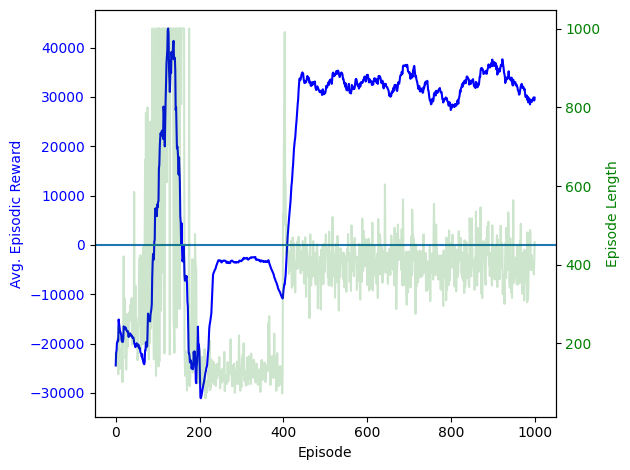

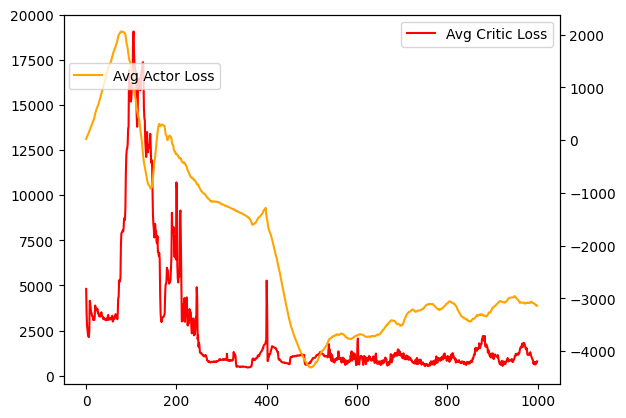

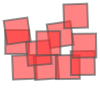

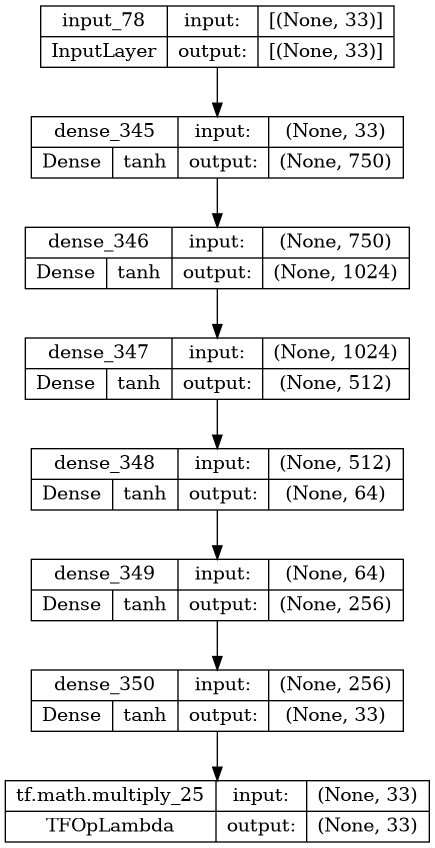

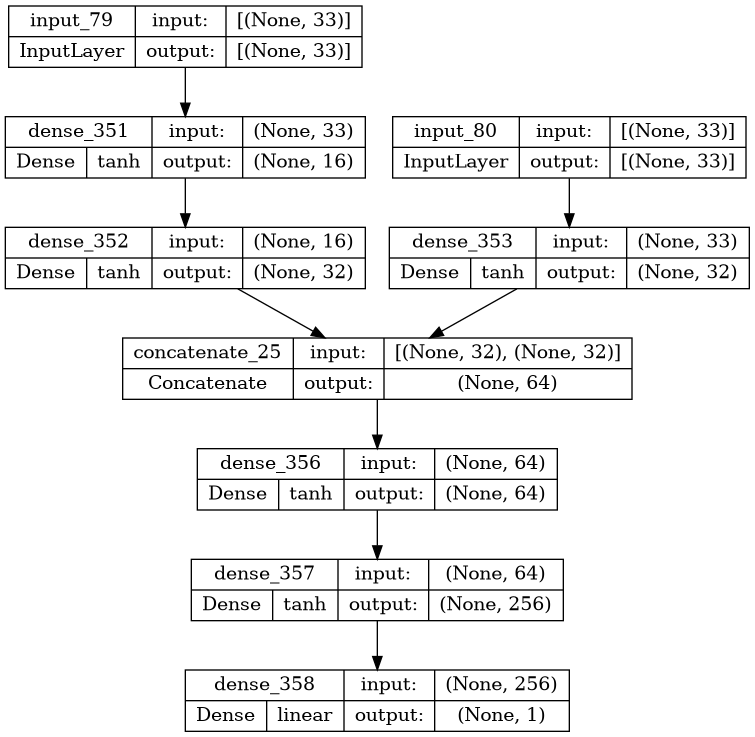

In [ ]:
#| code-fold: true
#| code-summary: "Display Log"
display(clear=True)
run()

In [37]:
#| code-fold: true
#| code-summary: "Save the weights outside of the log"
actor_model.save_weights(actor_weights_file)
critic_model.save_weights(critic_weights_file)

target_actor.save_weights(target_actor_weights_file)
target_critic.save_weights(target_critic_weights_file)


## Summary

I wasn't able to find a better configuration than the best known (which isn't super surprising). I didn't actually end up seeing much progress. Having trained a couple DDPG's before, I know usually you start *at least* seeing progress after a couple hundred episodes of training. This problem is much harder than the ones I've worked on before, but I didn't see really *any* progress after 500 episodes.

You can see the specific hyperparameters and configurations I tried (on GitHub)[https://github.com/smartycope/SquarePacking/tree/master/runs]

When you try a bunch of things, and none of them seem to work *at all*, it becomes hard to know what to try next. 

### My Guesses as to What is Wrong
- I overlooked some simple or not-so-simple flaw in the algorithm I set up, and it's not training because I set it up wrong
    - Solutions: 
        - Have someone who knows much more than I do about RL algorithms go over my code with a fine-toothed comb and implement what they suggest
- My observation space is too "abstract" (for lack of a better word), and doesn't adequately encode the positional relationships between the squares
    - Solutions:
        - Make the observation space multi-dimentional (say, a shape of `(11, 3)` instead of `(33,)`), and try adding a convolutional layer as the first layer of the actor network
        - Change the observation space to be a screen, and add a few convolutional layers as the first layers of the actor network
- The problem is fundementally too difficult to be solved with a DDPG
    - Solutions:
        - Switch to a different kind of ML architecture, like a transformer network
        - Try a different kind of heuristic algorithm...


### A Different Kind of Hueristic Algorithm
If I had more time, and was willing to scrap everything and start over, I would try a more monte carlo/simulated annealing approach. Something like this:

1. randomly make discrete movements/rotations of `rot_rate`, `shift_rate`
2. decide if it's better or not according to my reward function
3. if it's better, keep going, if it's worse, undo it some of the time, and keep it anyway some of the time (`r`)

Then, have `rot_rate`, `shift_rate`, and `r` decrease slowly as time goes on, to slowly anneal to a more optimal configuration.

Credit where it's due, the idea for this was inspired by [this YouTube video](https://www.youtube.com/watch?v=Lq-Y7crQo44&pp=ygUVZ2VycnltYW5kZXJpbmcgYWxwaGEg) on algorithmic gerrymandering

#### I did it
I ended up implementing that algorithm after all. Here it is, I'll only go into detail about the parts that I haven't discussed above. I used the same environment and hardware to run it as I did above.

I added cooldown to the variables `rand` (the chance that we make a bad move), `rot` (the max amount of rotation we can make in a single step), and `shift` (the max amount of translation we can make in a single step). You can see the graph below for the rates at which they decrease.

Inspired by [the above YouTube video](https://www.youtube.com/watch?v=Lq-Y7crQo44&pp=ygUVZ2VycnltYW5kZXJpbmcgYWxwaGEg), I tried adding an `overlap phase`. My thinking was that after it starts to approach a local minimum, a lower minimum may be blocked by say, the corner of a different square. If it could just get over there, it would be able to optimize further. This didn't end up working, and seemed to just make squares overlap, which reduced the reward and had a hard time getting back.

Note that this portion is independantly runnable, but you will need to run the `Dependant Code` section first for it to work.

In [8]:
#| code-fold: true
#| code-summary: "Imports"
import numpy as np
from random import randint
import random
import time
import matplotlib.pyplot as plt
import itertools as it
# from Cope import percent
# from SquareEnv2 import space2MultiPolygon, SquareEnv

In [23]:
#| filename: "Reward Function"
# Modify the reward function
def _get_reward(self):
    # We generally prefer living longer
    score = 0 # Linear
    centered_importance = .5 # Exponential

    score -= self.side_len

    # We don't like it when they overlap at all
    if self.overlap_area > 0:
        score -= 10
        # We also want to disincentivize overlapping more, so we can tell if we're starting to
        # un-overlap (which is better than overlapping more)
        score -= self.overlap_area

    # I don't want them to just push up against the edges
    if centered_importance:
        for x, y, _rot in self.squares:
            # Remove boundary badness entirely for optimization

            # We want the squares to be close to the center
            if centered_importance:
                score -= dist([x, y], [self.search_space / 2, self.search_space / 2]) * centered_importance

    return score


SquareEnv._get_reward = _get_reward

In [24]:
#| code-fold: true
#| code-summary: "modify the environment terminated function"
def _get_terminated(self):
    # Optimal: 3.789, best known: 3.877084
    # There's no overlapping and we're better than the previous best
    if self.N == 11 and self.side_len < 3.877084 and self.is_valid():
        print('Holy cow, we did it!!!')
        print('Coordinates & Rotations:')
        print(self.squares)
        with open('~/SQUARE_PARAMETERS.txt', 'w') as f:
            f.write(str(self.squares))
        return True

    # If we're almost entirely overlapping, just kill it
    if self.overlap_area > self.max_overlap:
        return True

    # Remove the deadlock detection, since it breaks when we only move 1 square at a time

    return False

SquareEnv._get_terminated = _get_terminated

In [25]:
#| filename: "Configuration & Enviorment"
env = SquareEnv(
    N=11,
    # It can handle a smaller search space, it speeds things up a little
    search_space=5.5,
    render_mode="pygame",
    # These are the upper bounds
    shift_rate=.05,
    rot_rate=.03,
    max_steps=100_000,
    bound_method='mixed',
    # This changes later
    disallow_overlap=True,
    boundary=0,
    # Arbitrarily high overlap: to allow for an "overlap phase" (see below)
    max_overlap=5,
    # I tried both `valid` and `array`
    start_config='valid',
    screen_size=(300, 400),
)

In [26]:
#| filename: "Hyperparameters"
# How many resets we're running for.
total_episodes = 1

# The starting constants
rand = .5 # Percent
# The starting rates will always be the highest
rot = env.rot_rate
shift = env.shift_rate

# The smallest they're allowed to get
_min_rand = .01 # percent
_min_rot = .0001
_min_shift = .0001

# How much we allow the probability to be modified, based on the score difference
rand_modify_limit = lambda rand: rand * .5

# The steps at which each phase starts and ends
# This is disabled at the moment: I found it tended to hinder more than help
overlap_phase = (env.max_steps * 2, -1)

# Specify a manual rand value while in the overlap_phase (to encourage exploration)
overlap_phase_rand = rand

# The cooldown functions
# These specify how we want to "cooldown" or decrease the values rand, rot, and shift over steps
# There's a lot of oppritunity for tuning these functions. In particular, I want to expirement with
# rot and shift functions that are "hilly", and increase and decrease the movement rates cyclicly.
cooldown = True
rand_func  = lambda step: (
    overlap_phase_rand
    if step > overlap_phase[0] and step < overlap_phase[1]
    else np.clip(-.000003*step  + rand,  _min_rand, rand)
)
rot_func   = lambda step: np.clip(-.0000002*step + rot,   _min_rot, rot)
shift_func = lambda step: np.clip(-.0000003*step + shift, _min_shift, shift)

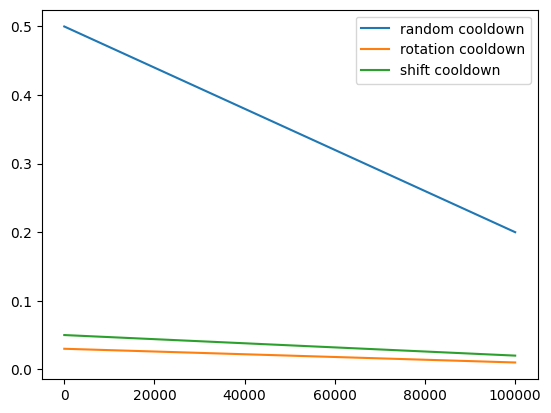

In [27]:
#| code-fold: true
#| code-summary: "Make a graph of the cooldown rates"
x = np.array(range(1, env.max_steps if env.max_steps > 1 else 100_000))
plt.plot(x, list(map(rand_func, x)), label='random cooldown')
plt.plot(x, rot_func(x), label='rotation cooldown')
plt.plot(x, shift_func(x), label='shift cooldown')
plt.legend()
plt.show()

In [28]:
#| code-fold: true
#| code-summary: "Show our configuration in the window"
env.show_strings = [
    '-------------------------',
    'Env Config:',
    f'Number of Squares: {env.N}',
    f'Max Steps: {env.max_steps}',
    f'Max Overlap: {env.max_overlap}',
    f'Shift Rate: {env.shift_rate}',
    f'Rotation Rate: {env.rot_rate}',
    f'Start Config: {env.start_config}',
    f'Boundary: {env.boundary}',
    f'Bound Method: {env.bound_method}',
    '-------------------------',
]

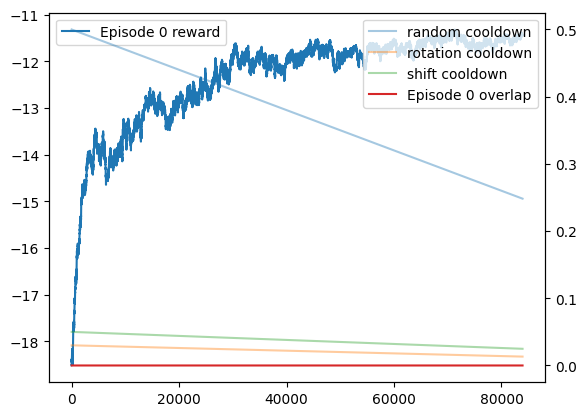

Best side length yet:  4.2757519302189095
Best Reward yet:  -11.537943776434863
Best State:
[2.33215984 1.64005651 1.23660412 2.85851348 3.68318778 1.35392014
 0.97938896 3.20995917 1.17055286 4.056265   4.44360427 1.51664717
 3.90260406 2.22845498 1.22983613 2.92982993 2.53654343 1.21451204
 1.85830051 4.03639402 1.39096229 3.84755382 3.34973736 1.36236215
 3.30502829 1.3204964  1.26810013 1.22718773 1.96212431 1.24175536
 1.93874577 2.88557254 1.15993837]


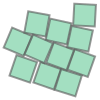

In [29]:
#| filename: "Main Loop"

# To store reward history of each episode (for plotting)
reward_lists = []
overlap_lists = []
best_state_yet = None
best_reward_yet = -10000000000
best_side_len_yet = 11
# Ensure this is set at the beginning of each new run
env.disallow_overlap = True

try:
    # Run through `total_episodes` number of enviorment resets
    for ep in range(total_episodes):
        prev_state, _ = env.reset()
        prev_reward = env._get_reward()
        episodic_reward = 0
        reward_lists.append([])
        overlap_lists.append([0])
        start_time = time.time_ns()

        # Run/step through a single episodes
        for step in it.count(1):
            env.render()
            # Calculate the cooldown values for this step
            # Underscored variables here indicate variables that get reset each step
            _rand = rand_func(step) if cooldown else rand
            _shift = shift_func(step) if cooldown else shift
            _rot = rot_func(step) if cooldown else rot
            _overlap_phase = step > overlap_phase[0] and step < overlap_phase[1]
            _rand_limit = rand_modify_limit(_rand)

            # Allow overlap, if we're in the overlap phase
            if _overlap_phase:
                env.disallow_overlap = False

            # Make a random action
            # Only move one square at a time: if we move all at the same time, then 3 of them might
            # be really good moves, but one is a bad move that invalidates all of them.
            action = np.zeros((env.N, 3))
            action[randint(0, env.N-1)] = [
                # TODO: Next, I want to try expirmenting with other statistical distrobutions
                random.uniform(-_shift, _shift),
                random.uniform(-_shift, _shift),
                random.uniform(-_rot, _rot),
            ]
            # TODO: optimization: we're flattening here to then immediately unflatten in the environment _step method
            action = action.flatten()

            # Recieve state and reward from environment
            state, reward, done, _, info = env.step(action)

            # Modify the chance of accepting the change based on the amount of reward difference: but limit to between
            # +/- _rand_limit, since a negative percentage doesn't make much sense, and we still want some randomness
            _chance = _rand + np.clip((prev_reward - reward) * 10, -_rand_limit, _rand_limit)

            # If we're overlapping more than we were before, minimize the odds that we'll keep the movement
            # NOTE: We can't set _chance to 0 here, or else once we overlap during the overlap phase, we won't be able
            # to get out
            if not _overlap_phase and info['overlap'] > overlap_lists[ep][-1]:
                _chance = _rand - _rand_limit

            if (
                (
                    # If we're overlaping at all, and it's not the overlap phase, or if our current state is worse than
                    # the one before we made the move, undo the move we just took `_chance`% of the time.
                    # We don't want to do it *all* the time, because we'd quickly only find the local minumum.
                    # This is the premise of simulated annealing
                    (info['overlap'] > 0 and not _overlap_phase)
                    or
                    reward < prev_reward
                )
                and not percent(_chance)
            ):
                # Step back - undo what we just did
                state, reward, done, _, info = env.step(-action)

            # If we've finished the overlap phase, and we've gotten to a point where we're no longer overlapping,
            # disable overlap again
            if not env.disallow_overlap and not info['overlap']:
                env.disallow_overlap = True

            # ------------------ Not part of the algorithm --------------------
            reward_lists[ep].append(reward)
            overlap_lists[ep].append(info['overlap'])

            if best_side_len_yet > info['len']:
                best_state_yet = state
                best_side_len_yet = info['len']
                best_reward_yet = reward

            episodic_reward += reward
            env.print['e'] = f'Episode {env.reset_count}/{total_episodes}:'
            env.print['step'] = f'Step: {step:.0f}'
            env.print['reward'] = f'Reward: {reward:.3f}'
            env.print['overlap'] = f'Overlap: {info["overlap"]:.5f}'
            env.print['len'] = f'Side Length: {info["len"]:.1f}'
            env.print['wasted'] = f'Wasted Space: {info["wasted"]:.1f}'
            env.print['_rand'] = f'annealing coeff: {_rand:.5f}'
            env.print['_shift'] = f'shift rate: {_shift:.5f}'
            env.print['_rot'] = f'rotation rate: {_rot:.5f}'
            env.print['avg reward'] = f'Avg. Reward for This Episode: {episodic_reward/step:.2f}'
            env.print['phase'] = f"Phase: {'Overlap' if _overlap_phase else 'Main'}"
            env.print['eee'] = f'_rand: {_chance:.2%}'
            env.print['j'] = f'{((time.time_ns() - start_time)/1000_000) / step:.2f}ms / step'

            if done: break

            prev_state = state
            prev_reward = reward

finally:
    env.close()
    if best_reward_yet is not None:
        # Make the graph, and display some of the output
        env.display()

        fig, ax1 = plt.subplots()

        for ep, i in enumerate(reward_lists):
            ax1.plot(i, label=f'Episode {ep} reward')

        ax2 = ax1.twinx()
        x = np.array(range(len(max(reward_lists, key=len))))
        ax2.plot(x, list(map(rand_func, x)), label='random cooldown', alpha=.4)
        ax2.plot(rot_func(x), label='rotation cooldown', alpha=.4)
        ax2.plot(shift_func(x), label='shift cooldown', alpha=.4)

        for ep, i in enumerate(overlap_lists):
            ax2.plot(i, label=f'Episode {ep} overlap')

        ax1.legend()
        ax2.legend()
        # ax1.vlines(overlap_phase, -22, -3)
        plt.show()
        print('Best side length yet: ', best_side_len_yet)
        print('Best Reward yet: ', best_reward_yet)
        print('Best State:')
        print(best_state_yet)

        display(space2MultiPolygon(best_state_yet.reshape((env.N,3)), 1))


![This is what it looks like when it's running](index.png)

This is a graph of when I tried using the `overlap_phase`. In the reward function, I disincentivized overlapping at all, and then additionally disincentivized the amount of overlap. As you can see, once overlap is allowed, it starts doing so, and the reward plumets. I don't want to stop disincentivizing overlap during the overlap phase, because then it would quickly all collapse to the center. I ended up removing the overlap phase entirely based on this graph, because you can see the reward increasing, and suddenly dropping, and then rising back up to along the same curve as you can see in the graph above.

In [ ]:
#| eval: false
#| echo: false
ang = .0000000001
trivial = space2MultiPolygon(np.array([
    .5, .5, 0,
    1.5+ang, 1.5+ang, 0,
    1.5+ang, .5, 0,
    .5, 1.5+ang, 0,
    2.5+ang*2, 2.5+ang*2, 0,
    2.5+ang*2, 1.5+ang, 0,
    1.5+ang, 2.5+ang*2, 0,
    0.5, 2.5+ang*2, 0,
    0.5, 3.5+ang*3, 0,
    2.5+ang*2, 0.5, 0,
]))
display(trivial)
env.state = trivial
env._get_info()

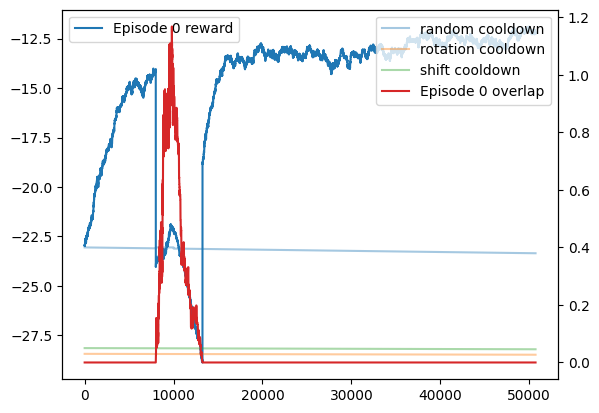

## Summary Part 2

Using the simulated annealing method ended up working significantly better than the DDPG algorithm. You can actually see it making progress while it's running, and while the reward values aren't comparable, the graphs clearly show improvement while using simulated annealing as opposed to the DDPG algorithm.

I wasn't able to find a better configuration than the best known, the best I could do was ~4.276. However, I feel like there's still untapped potential here. I only started on the 2nd algorithm in the last couple of days, and plan to continue to fine-tune it going forward.

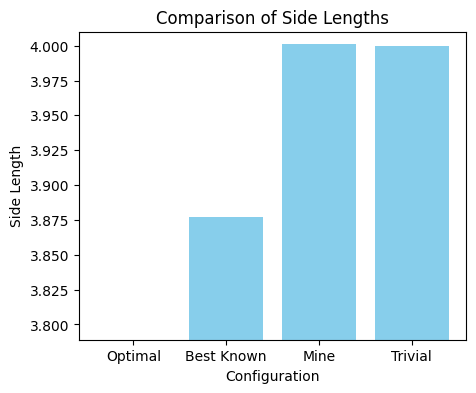

In [6]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
data = {
    'config': [3.789, 3.877, 4.001, 4.],
    'label': ['Optimal', 'Best Known', 'Mine', 'Trivial']
}
df = pd.DataFrame(data)

plt.figure(figsize=(5, 4))
plt.bar(df['label'], df['config'], color='skyblue')

plt.xlabel('Configuration')
plt.ylabel('Side Length')
# plt.title('')
plt.ylim(3.789, 4.01)
plt.title('Comparison of Side Lengths')
# Display the plot
plt.show()



| Configuration      | Side length | Image |
|--------------------|-------------|-------|
| Optimal | 3.789       | ???   |
| Best Known         | 3.877       | 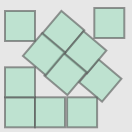 |
| Trivial            | 4.000       | 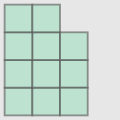 |
| Mine               | 3.920       | 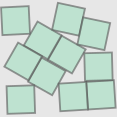|
| Mine               | 3.947       | 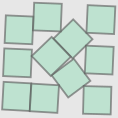|
| Mine               | 3.949       | 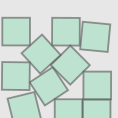|
| Mine               | 4.001       | 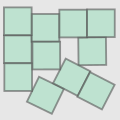|



|Side Length|3.920|3.947|
|---|---|---|
|Close to Best Known |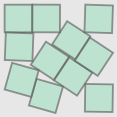3.920|-|
|Threes|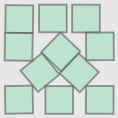|.|